#### Background
As smart phone penetration reaches the hundreds of millions mark, O2O (Online to Offline) requires businesses to have a strong presence both offline and online. APPs with O2O capabilities accumulate daily consumer behaviour and location data that require big data and commercial operations management. The competition at hand focuses on coupon redemption rates. Sending coupons is a general O2O marketing tool used to activate existing customers and attract new ones. While customers are happy to receive coupons that they want, they are frustrated when receiving coupons that they do not need. For merchants, sending unwanted coupons may erode brand equity and hinder marketing expense forecasting. Targeted marketing is an important technology to increase the coupon redemption rate, providing relevant discounts to customers and effective marketing tools to businesses. The competition provides participants with abundant O2O data in this field and expects contestants to predict whether the customer will use the coupon within a specified time frame.
### Data
This competition provides real online and offline user consumption data from January 1, 2016 to June 30, 2016. The contestants are expected to predict the probability of customers redeeming a coupon within 15 days of receiving it.
Note: To protect the privacy of users and merchants, data is desensitized and under biased sampling.
### Evaluation
The results are evaluated based on the average AUC value. That is, the AUC value is calculated for every coupon_id. The average of each AUC value is the evaluation score. More information on AUC value calculation method on wikipedia.


### Test Data

In [3]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
df_test=  pd.read_csv('ccf_offline_stage1_test_revised.csv')
print(df_test.shape)
df_test.head()

(113640, 6)


,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received
0,4129537,450,9983,30:5,1.0,20160712
1,6949378,1300,3429,30:5,NaN,20160706
2,2166529,7113,6928,200:20,5.0,20160727
3,2166529,7113,1808,100:10,5.0,20160727
4,6172162,7605,6500,30:1,2.0,20160708


In [7]:
df_test.isna().sum()

User_id              0
Merchant_id          0
Coupon_id            0
Discount_rate        0
Distance         12064
Date_received        0
dtype: int64

In [8]:
#List of coupon ids in test data
coupon_ids_test = df_test[(df_test["Coupon_id"].isna()==False)]
coupons_test = np.array(coupon_ids_test["Coupon_id"].astype(int))
coupons_test

array([ 9983,  3429,  6928, ...,  7590, 13602,   613])

### Training Offline Data

In [10]:
df_of = pd.read_csv('ccf_offline_stage1_train.csv')
print(df_of.shape)
df_of.head()

(1754884, 7)


,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date
0,1439408,2632,NaN,NaN,0.0,NaN,20160217.0
1,1439408,4663,11002.0,150:20,1.0,20160528.0,NaN
2,1439408,2632,8591.0,20:1,0.0,20160217.0,NaN
3,1439408,2632,1078.0,20:1,0.0,20160319.0,NaN
4,1439408,2632,8591.0,20:1,0.0,20160613.0,NaN


In [11]:
df_of.isna().sum()

User_id               0
Merchant_id           0
Coupon_id        701602
Discount_rate    701602
Distance         106003
Date_received    701602
Date             977900
dtype: int64

In [12]:
#User_ids and its frequency
df_of['User_id'].value_counts().head()

5054119    264
2751537    155
2949273    137
6655171    136
4840568    134
Name: User_id, dtype: int64

In [13]:
#Coupon ids for offline data
df_of.Coupon_id.describe()

count    1.053282e+06
mean     6.815398e+03
std      4.174276e+03
min      1.000000e+00
25%      2.840000e+03
50%      7.430000e+03
75%      1.032300e+04
max      1.404500e+04
Name: Coupon_id, dtype: float64

In [14]:
#number of unique coupon ids for offline training data
df_of.Coupon_id.nunique()

9738

In [15]:
#list of coupon ids for offline training data
coupon_ids_of = df_of[(df_of["Coupon_id"].isna()==False)]
coupons_of = coupon_ids_of["Coupon_id"].astype(int).unique()
min(coupons_of)

1

In [11]:
#number of unique coupons for test and offline training data
len(set(coupons_of).intersection(set(coupons_test)))

1118

In [17]:
df_of.columns

Index(['User_id', 'Merchant_id', 'Coupon_id', 'Discount_rate', 'Distance',
       'Date_received', 'Date'],
      dtype='object')

In [19]:
#Removing duplicates and giving frequency counts to each row
x = 'g8h.|$hTdo+jC9^@'   #garbage value for nan values 
df_of_unique = (df_of.fillna(x).groupby(['User_id', 'Merchant_id', 'Coupon_id', 'Discount_rate', 'Distance',
       'Date_received', 'Date']).size().reset_index()
               .rename(columns={0 : 'Count'}).replace(x,np.NaN))
df_of_unique.head()

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date,Count
0,4,1433,8735.0,30:5,10.0,20160214.0,NaN,1
1,4,1469,2902.0,0.95,10.0,20160607.0,NaN,1
2,35,3381,1807.0,300:30,0.0,20160130.0,NaN,1
3,35,3381,9776.0,10:5,0.0,20160129.0,NaN,1
4,35,3381,11951.0,200:20,0.0,20160129.0,NaN,1


In [20]:
#Changing Date and Date Received to DateTime format
df_of_unique['Date'] = pd.to_datetime(df_of_unique["Date"],format='%Y%m%d')
df_of_unique['Date_received'] = pd.to_datetime(df_of_unique["Date_received"],format='%Y%m%d')
df_of_unique.head()

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date,Count
0,4,1433,8735.0,30:5,10.0,2016-02-14,NaT,1
1,4,1469,2902.0,0.95,10.0,2016-06-07,NaT,1
2,35,3381,1807.0,300:30,0.0,2016-01-30,NaT,1
3,35,3381,9776.0,10:5,0.0,2016-01-29,NaT,1
4,35,3381,11951.0,200:20,0.0,2016-01-29,NaT,1


In [16]:
# where distance and date of purchase not given
df_of[(df_of['Distance'].isna()) & (df_of['Date'].isna())]

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date
13,2747744,6901,1097.0,50:10,NaN,20160606.0,NaN
17,73611,2099,12034.0,100:10,NaN,20160207.0,NaN
24,343660,4663,11002.0,150:20,NaN,20160528.0,NaN
52,106443,450,3732.0,30:5,NaN,20160429.0,NaN
58,2621792,4433,190.0,200:20,NaN,20160131.0,NaN
...,...,...,...,...,...,...,...
1754771,2346848,7555,17.0,30:5,NaN,20160204.0,NaN
1754772,2346848,6284,7379.0,50:10,NaN,20160204.0,NaN
1754844,457900,7907,13118.0,150:30,NaN,20160418.0,NaN
1754848,4056416,7177,3469.0,20:1,NaN,20160514.0,NaN


When distance and date of purchase are not given, it can be the case where coupons are given through some other medium(online)

### Training Online Data

In [22]:
df_on = pd.read_csv('ccf_online_stage1_train.csv')
print(df_on.shape)
df_on_total = df_on.shape[0]
df_on.head()

(11429826, 7)


,User_id,Merchant_id,Action,Coupon_id,Discount_rate,Date_received,Date
0,13740231,18907,2,100017492,500:50,20160513.0,NaN
1,13740231,34805,1,NaN,NaN,NaN,20160321.0
2,14336199,18907,0,NaN,NaN,NaN,20160618.0
3,14336199,18907,0,NaN,NaN,NaN,20160618.0
4,14336199,18907,0,NaN,NaN,NaN,20160618.0


In [23]:
df_on.isna().sum()

User_id                 0
Merchant_id             0
Action                  0
Coupon_id        10557469
Discount_rate    10557469
Date_received    10557469
Date               655898
dtype: int64

In [24]:
#List of coupon ids for online training data
coupon_ids_on = df_on[(df_on["Coupon_id"].isna()==False) & (df_on["Coupon_id"]!='fixed')]
coupons_on = coupon_ids_on["Coupon_id"].astype(int).unique()
#number of common coupon ids for test and training online data
len(set(coupons_on).intersection(set(coupons_test)))

0

In [19]:
#Date==Null and Coupon_id==Null: no such cases
df_on[(df_on["Date"].isna()) & (df_on["Coupon_id"].isna())].shape

(0, 7)

In [27]:
#Date==Null and Coupon_id!=Null: Coupon not redeemed(5.73%) and customer only 'gets Coupon'
#All values for action is 2
df_not_redeemed = df_on[(df_on["Date"].isna()) & (df_on["Coupon_id"].isna()==False)]
df_not_redeemed.shape[0] == df_not_redeemed[df_not_redeemed['Action']==2].shape[0]

True

In [28]:
df_not_redeemed["Action"].describe()

count    655898.0
mean          2.0
std           0.0
min           2.0
25%           2.0
50%           2.0
75%           2.0
max           2.0
Name: Action, dtype: float64

In [29]:
#Date!=Null and Coupon_id==Null: No coupon(92.36%) and the customer only 'clicks' and 'buys'
df_no_coupon = df_on[(df_on["Date"].isna()==False) & (df_on["Coupon_id"].isna())]
df_no_coupon.shape

(10557469, 7)

In [30]:
df_no_coupon["Action"].unique()

array([1, 0])

In [31]:
#82.23% times customer only clicks
df_no_coupon[df_no_coupon["Action"]==0].shape

(9401780, 7)

In [32]:
#10.11% times customer buys with no coupon
df_no_coupon[df_no_coupon["Action"]==0].shape

(9401780, 7)

In [33]:
#coupon redeemed 1.89% times ('buys') (Date!=Null and Coupon_id!=Null)
df_redeemed = df_on[(df_on["Date"].isna()==False) & (df_on["Coupon_id"].isna()==False)]
df_redeemed.shape

(216459, 7)

In [34]:
df_redeemed["Action"].unique()

array([1])

In [36]:
#number of unique values for each column
df_on.nunique(axis = 0) 

User_id          762858
Merchant_id        7999
Action                3
Coupon_id         27747
Discount_rate        64
Date_received       167
Date                182
dtype: int64

In [37]:
df_on.groupby(['User_id','Merchant_id']).head()

,User_id,Merchant_id,Action,Coupon_id,Discount_rate,Date_received,Date
0,13740231,18907,2,100017492,500:50,20160513.0,NaN
1,13740231,34805,1,NaN,NaN,NaN,20160321.0
2,14336199,18907,0,NaN,NaN,NaN,20160618.0
3,14336199,18907,0,NaN,NaN,NaN,20160618.0
4,14336199,18907,0,NaN,NaN,NaN,20160618.0
...,...,...,...,...,...,...,...
11429821,13087731,27715,0,NaN,NaN,NaN,20160629.0
11429822,13087731,52005,0,NaN,NaN,NaN,20160324.0
11429823,13087731,45611,0,NaN,NaN,NaN,20160422.0
11429824,13683699,18009,1,NaN,NaN,NaN,20160323.0


In [38]:
#When coupon==fixed, coupon redeemed the same day
df_fix = df_on[df_on["Coupon_id"]=="fixed"]
df_fix.shape, df_fix[df_fix["Date_received"]==df_fix["Date"]].shape

((131546, 7), (131546, 7))

In [39]:
df_on.index.name="Index"

In [40]:
# df_on[(df_on["User_id"]==14336199)]

In [41]:
# df_on[(df_on["User_id"]==10998966) & (df_on["Merchant_id"]==14305)]

In [42]:
df_on.columns

Index(['User_id', 'Merchant_id', 'Action', 'Coupon_id', 'Discount_rate',
       'Date_received', 'Date'],
      dtype='object')

In [43]:
df_on.drop_duplicates().shape

(5822543, 7)

In [45]:
#Removing duplicates and giving frequency counts(Count) to each row
x = 'g8h.|$hTdo+jC9^@'    
df_on_unique = (df_on.fillna(x).groupby(['User_id', 'Merchant_id', 'Action', 'Coupon_id', 'Discount_rate',
       'Date_received', 'Date']).size().reset_index()
               .rename(columns={0 : 'Count'}).replace(x,np.NaN))
df_on_unique.shape

(5822543, 8)

In [46]:
df_on_unique.Count.describe()

count    5.822543e+06
mean     1.963030e+00
std      3.430659e+00
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      6.300000e+02
Name: Count, dtype: float64

In [38]:
#Repetition of records
arr = list(df_on_unique["Count"])
arr.sort(reverse=True)
arr[:10]

[630, 504, 444, 432, 378, 367, 336, 336, 333, 322]

In [47]:
#number of unique values for each column
df_on_unique.nunique()

User_id          762858
Merchant_id        7999
Action                3
Coupon_id         27747
Discount_rate        64
Date_received       167
Date                182
Count               233
dtype: int64

In [41]:
# df_on_unique[df_on_unique["User_id"]==10998966]

In [51]:
df_online_actions= pd.concat([df_on_unique,pd.get_dummies(df_on_unique['Action'], prefix='Action',dummy_na=False)],axis=1)

#Getting action values based on the count value 
df_online_actions['Action_0'] = df_online_actions['Action_0'] * df_online_actions['Count']
df_online_actions['Action_1'] = df_online_actions['Action_1'] * df_online_actions['Count']
df_online_actions['Action_2'] = df_online_actions['Action_2'] * df_online_actions['Count']
# df_online_actions[df_online_actions['User_id']==10998966]
df_online_actions.head()


,User_id,Merchant_id,Action,Coupon_id,Discount_rate,Date_received,Date,Count,Action_0,Action_1,Action_2
0,4,25104,2,100145044,100:10,20160331.0,NaN,1,0,0,1
1,4,45612,1,NaN,NaN,NaN,20160308.0,1,0,1,0
2,36,46701,0,NaN,NaN,NaN,20160120.0,1,1,0,0
3,64,11200,0,NaN,NaN,NaN,20160526.0,1,1,0,0
4,64,29214,0,NaN,NaN,NaN,20160606.0,1,1,0,0


#### Finding buy:click ratio for each user

In [46]:

# df_online_actions = df_online_actions.groupby('User_id')['Action_1','Action_0'].sum()
# df_online_actions['buy_clicks'] = df_online_actions['Action_1']/df_online_actions['Action_0']
# df_online_actions  = df_online_actions.replace([np.inf, -np.inf], -1)
# df_online_actions["buy_clicks"].value_counts()

In [47]:
# df_online_actions_ = pd.DataFrame(df_online_actions).reset_index()

In [52]:
#Converting Date and Date_received to DateTime Format
df_on_unique['Date'] = pd.to_datetime(df_on_unique["Date"],format='%Y%m%d')
df_on_unique['Date_received'] = pd.to_datetime(df_on_unique["Date_received"],format='%Y%m%d')

In [53]:
df_on_unique.head()

,User_id,Merchant_id,Action,Coupon_id,Discount_rate,Date_received,Date,Count
0,4,25104,2,100145044,100:10,2016-03-31,NaT,1
1,4,45612,1,NaN,NaN,NaT,2016-03-08,1
2,36,46701,0,NaN,NaN,NaT,2016-01-20,1
3,64,11200,0,NaN,NaN,NaT,2016-05-26,1
4,64,29214,0,NaN,NaN,NaT,2016-06-06,1


### Users involved in both online and offline transactions

In [55]:
on_off = df_on_unique.append(df_of_unique, sort=False)

In [56]:
on_off.head()

,User_id,Merchant_id,Action,Coupon_id,Discount_rate,Date_received,Date,Count,Distance
0,4,25104,2.0,100145044,100:10,2016-03-31,NaT,1,NaN
1,4,45612,1.0,NaN,NaN,NaT,2016-03-08,1,NaN
2,36,46701,0.0,NaN,NaN,NaT,2016-01-20,1,NaN
3,64,11200,0.0,NaN,NaN,NaT,2016-05-26,1,NaN
4,64,29214,0.0,NaN,NaN,NaT,2016-06-06,1,NaN


In [62]:
users_on = set(df_on["User_id"].unique())           #number of users in online data
users_of = set(df_of["User_id"].unique())           #number of users in offline data
users_test = set(df_test["User_id"].unique())       #number of users in test data
users_on_off = set(users_of.intersection(users_on)) #number of users having both online and offline presence
len(users_on), len(users_on_of)

(762858, 267448)

In [63]:
#number of common users in (test and online data) and (test and offline data) 
len(users_test.intersection(users_on)), len(users_test.intersection(users_of))

(43155, 76307)

In [64]:
#number of users using only online and only offline services
len(users_on - users_on_off), len(users_of - users_on_off)

(495410, 271990)

In [65]:
merch_on = set(df_on["Merchant_id"].unique())        #number of Merchant in online data
merch_of = set(df_of["Merchant_id"].unique())        #number of Merchants in offline data
merch_test = set(df_test["Merchant_id"].unique())    #number of Merchants in test data

In [66]:
#number of common merchants in (test and online data) and (test and offline data) 
len(merch_test.intersection(merch_on)), len(merch_test.intersection(merch_of))

(0, 1558)

In [69]:
#dataset of users having both online and offline presence
on_off = on_off[on_off['User_id'].isin(list(users_on_off))]
on_off.shape

(2168771, 9)

In [70]:
on_off[on_off["User_id"]==36]

,User_id,Merchant_id,Action,Coupon_id,Discount_rate,Date_received,Date,Count,Distance
2,36,46701,0.0,NaN,NaN,NaT,2016-01-20,1,NaN
6,36,1041,NaN,13490,30:5,2016-01-25,NaT,1,4.0
7,36,5717,NaN,12349,20:5,2016-01-25,NaT,1,8.0


In [71]:
on_off = on_off.sort_values(by=['User_id'])

In [72]:
on_off.reset_index(drop=True, inplace=True)
on_off.head()

,User_id,Merchant_id,Action,Coupon_id,Discount_rate,Date_received,Date,Count,Distance
0,4,25104,2.0,100145044,100:10,2016-03-31,NaT,1,NaN
1,4,1469,NaN,2902,0.95,2016-06-07,NaT,1,10.0
2,4,1433,NaN,8735,30:5,2016-02-14,NaT,1,10.0
3,4,45612,1.0,NaN,NaN,NaT,2016-03-08,1,NaN
4,36,5717,NaN,12349,20:5,2016-01-25,NaT,1,8.0


In [73]:
# Clicks data of common user
on_off[(on_off["Action"]==0) & (on_off["Date"].isna()==False) & (on_off["Coupon_id"].isna()) ]

,User_id,Merchant_id,Action,Coupon_id,Discount_rate,Date_received,Date,Count,Distance
5,36,46701,0.0,NaN,NaN,NaT,2016-01-20,1,NaN
7,64,11200,0.0,NaN,NaN,NaT,2016-05-26,1,NaN
10,64,29214,0.0,NaN,NaN,NaT,2016-06-06,1,NaN
12,144,33502,0.0,NaN,NaN,NaT,2016-02-14,1,NaN
32,173,14414,0.0,NaN,NaN,NaT,2016-01-17,1,NaN
...,...,...,...,...,...,...,...,...,...
2168737,7360928,27712,0.0,NaN,NaN,NaT,2016-03-21,1,NaN
2168738,7360928,13104,0.0,NaN,NaN,NaT,2016-05-20,1,NaN
2168742,7360928,44706,0.0,NaN,NaN,NaT,2016-03-14,2,NaN
2168753,7360961,25104,0.0,NaN,NaN,NaT,2016-05-19,1,NaN


#### Number of coupon redemptions vs Date Plot (For Common users)

In [77]:
date_redeemed = on_off[(on_off["Date"].isna()==False) & (on_off["Coupon_id"].isna()==False)].Date

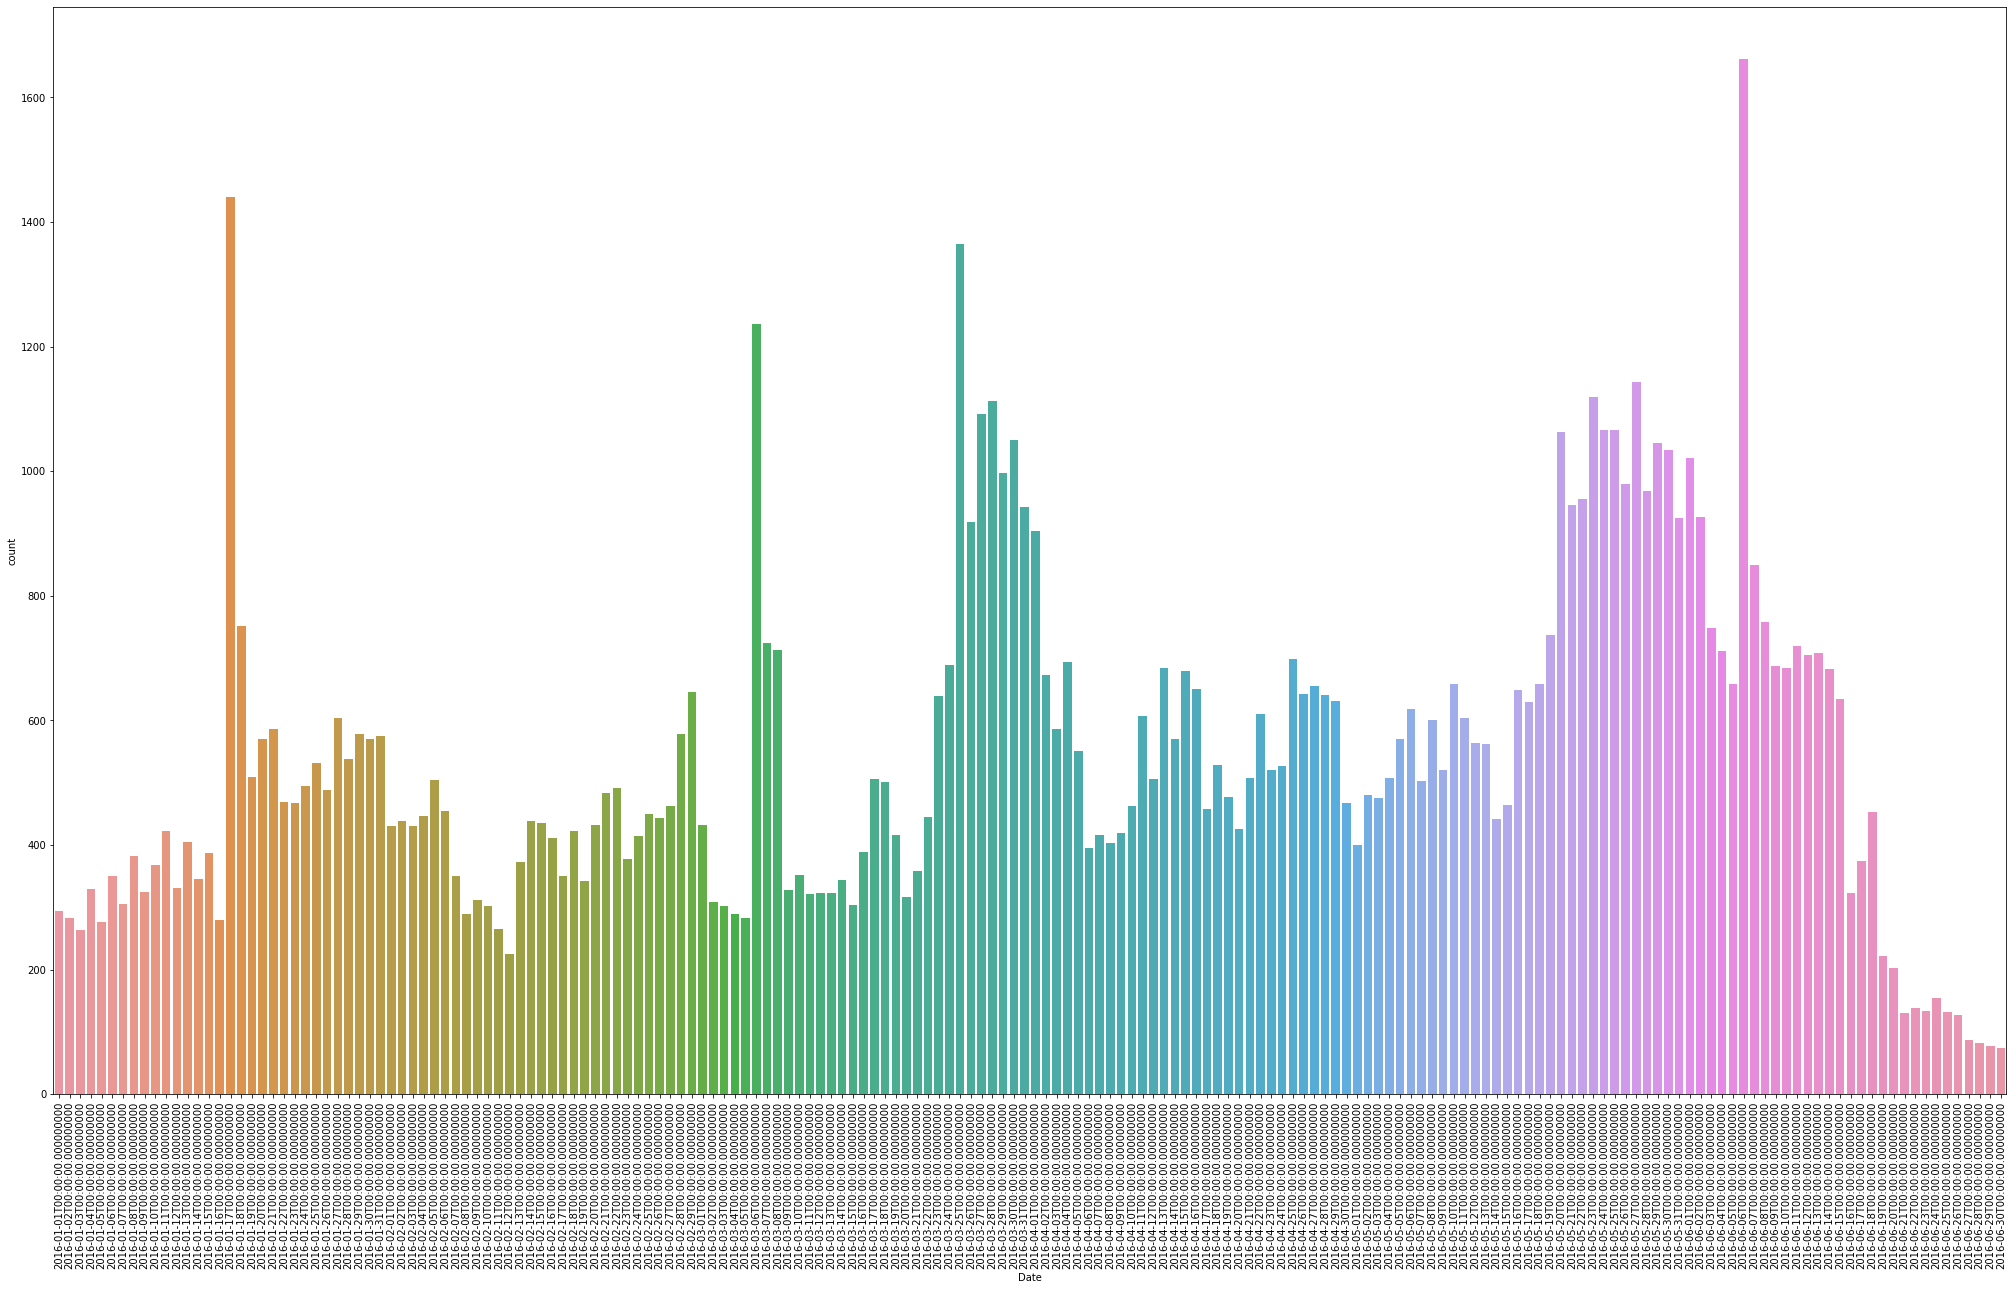

In [78]:
plt.figure(figsize=(35,20))
ax = sns.countplot(date_redeemed)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.show()

### Only Offline Users

In [79]:
#users having only online presence
df_offline = df_of_unique[df_of_unique['User_id'].isin(list(users_of - users_on_off))]
df_offline.head()

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date,Count
2,35,3381,1807.0,300:30,0.0,2016-01-30,NaT,1
3,35,3381,9776.0,10:5,0.0,2016-01-29,NaT,1
4,35,3381,11951.0,200:20,0.0,2016-01-29,NaT,1
5,35,3381,11951.0,200:20,0.0,2016-01-30,NaT,1
9,110,4433,190.0,200:20,NaN,2016-01-31,NaT,1


#### Numbear of coupon redemptions vs Date Plot (For only online users)

In [81]:
date_off_redeemed = df_offline[(df_offline["Date"].isna()==False) & (df_offline["Coupon_id"].isna()==False)]

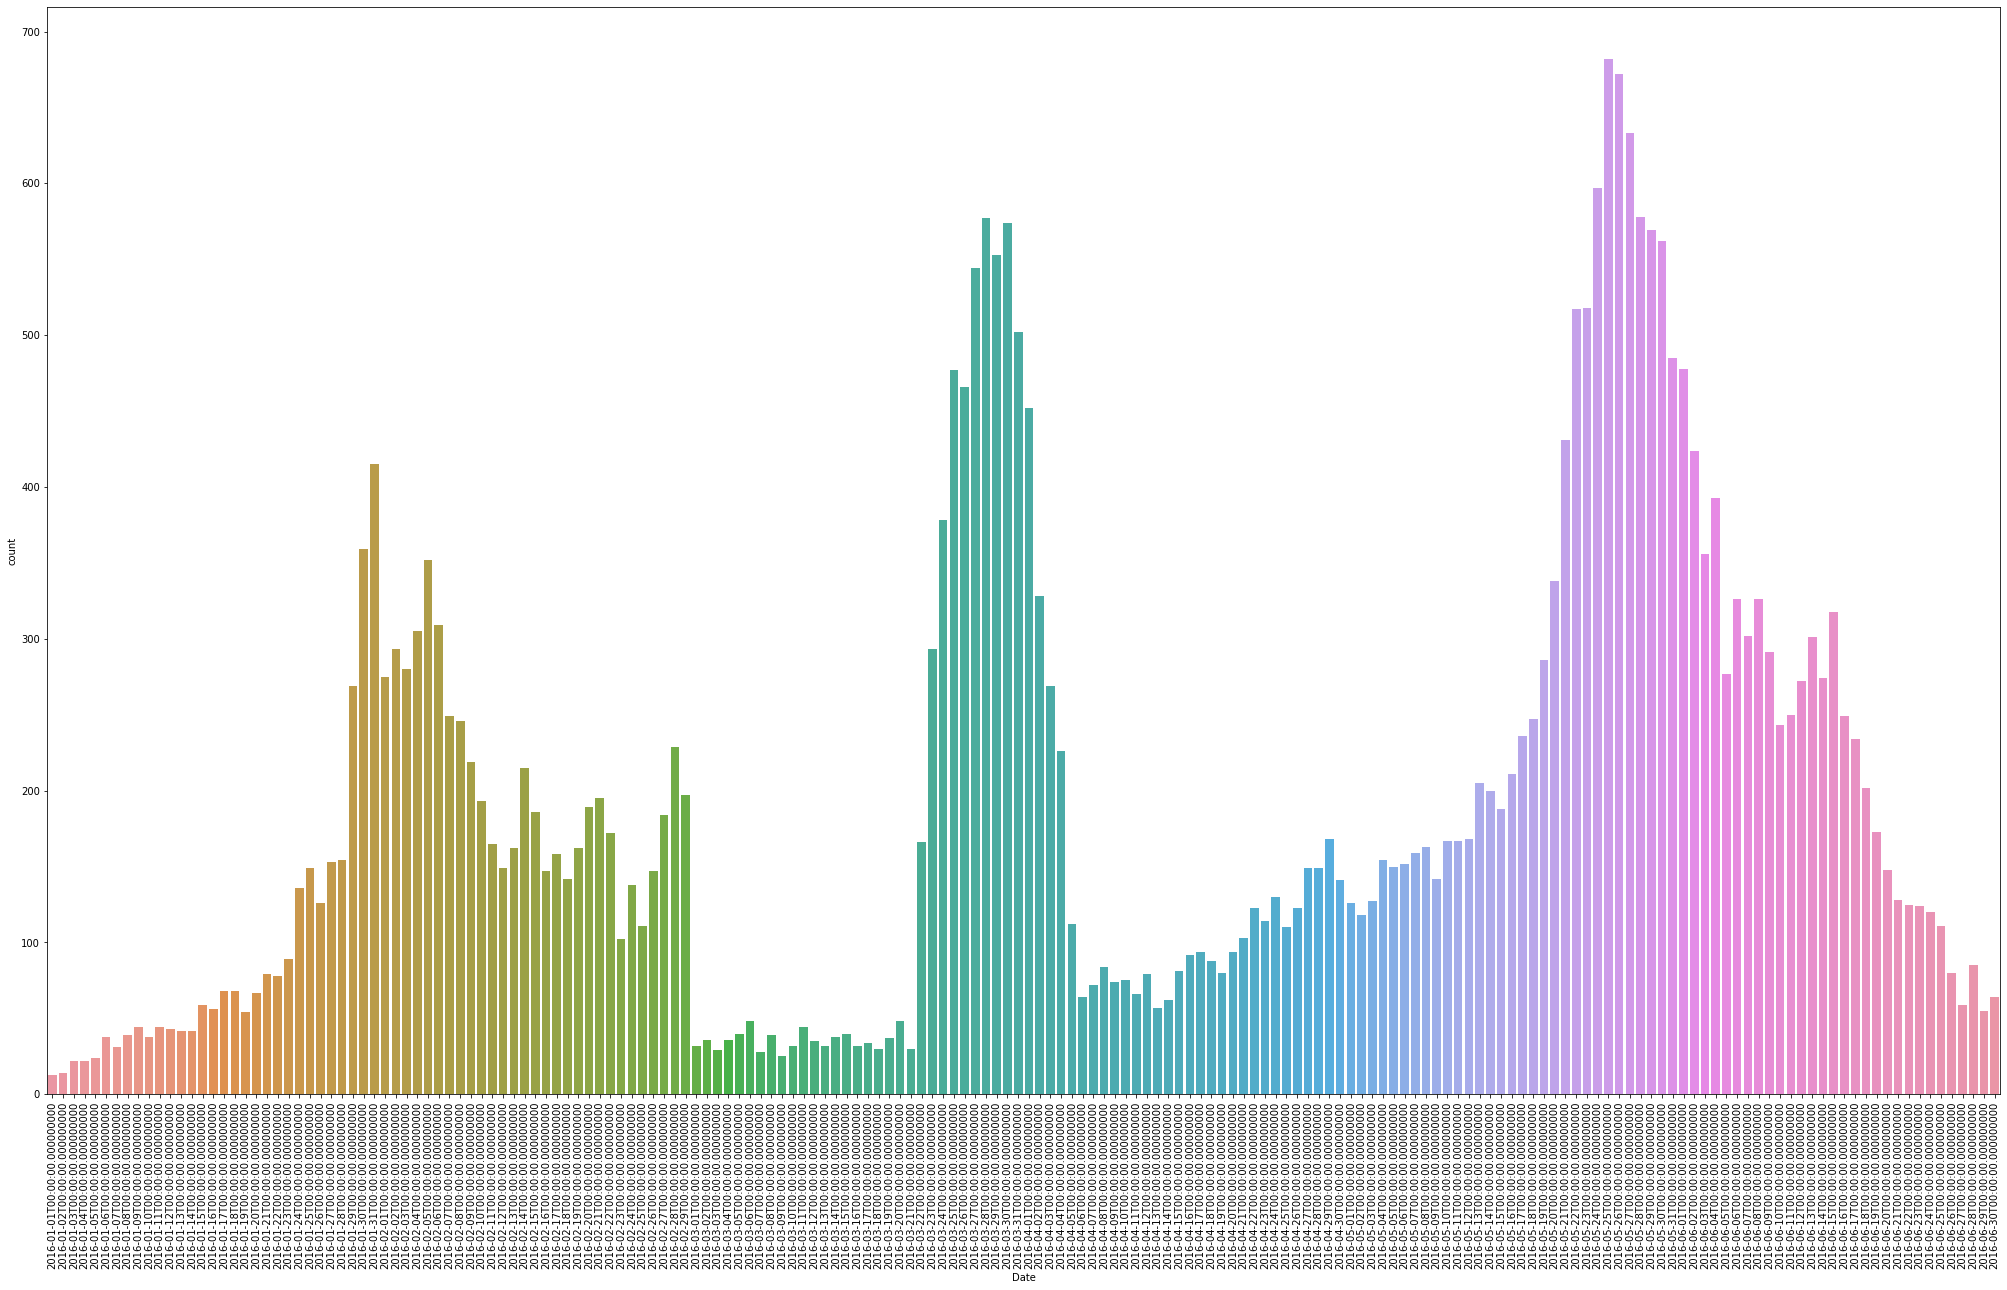

In [82]:
plt.figure(figsize=(35,20))
ax = sns.countplot(date_off_redeemed["Date"])
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.show()

In [83]:
#As online data has no clicks, so max repetition(exact same) of records is 12
np.sort(df_offline["Count"].unique())

array([ 1,  2,  3,  4,  5,  6,  7, 12])

In [88]:
#Number of visits of each user
activity_offline = df_offline.groupby("User_id")["Count"].sum()
activity_offline

User_id
35         4
110        3
147        1
166        1
228        1
          ..
7360825    2
7360845    3
7360952    1
7360966    1
7361024    1
Name: Count, Length: 271990, dtype: int64

In [89]:
df_activity_offline = pd.DataFrame(activity_offline).reset_index()
df_activity_offline.columns = ['User_id', 'ActivityCount']
df_activity_offline["ActivityCount"].describe()

count    271990.000000
mean          3.058050
std           4.645573
min           1.000000
25%           1.000000
50%           2.000000
75%           3.000000
max         137.000000
Name: ActivityCount, dtype: float64

### Only Online Users


In [86]:
df_online = df_on_unique[df_on_unique['User_id'].isin(list(users_on - users_on_off))]
date_redeemed_on = df_online[(df_online["Date"].isna()==False) & (df_online["Coupon_id"].isna()==False)]

#### Numbear of coupon redemptions vs Date Plot (For only offline users)

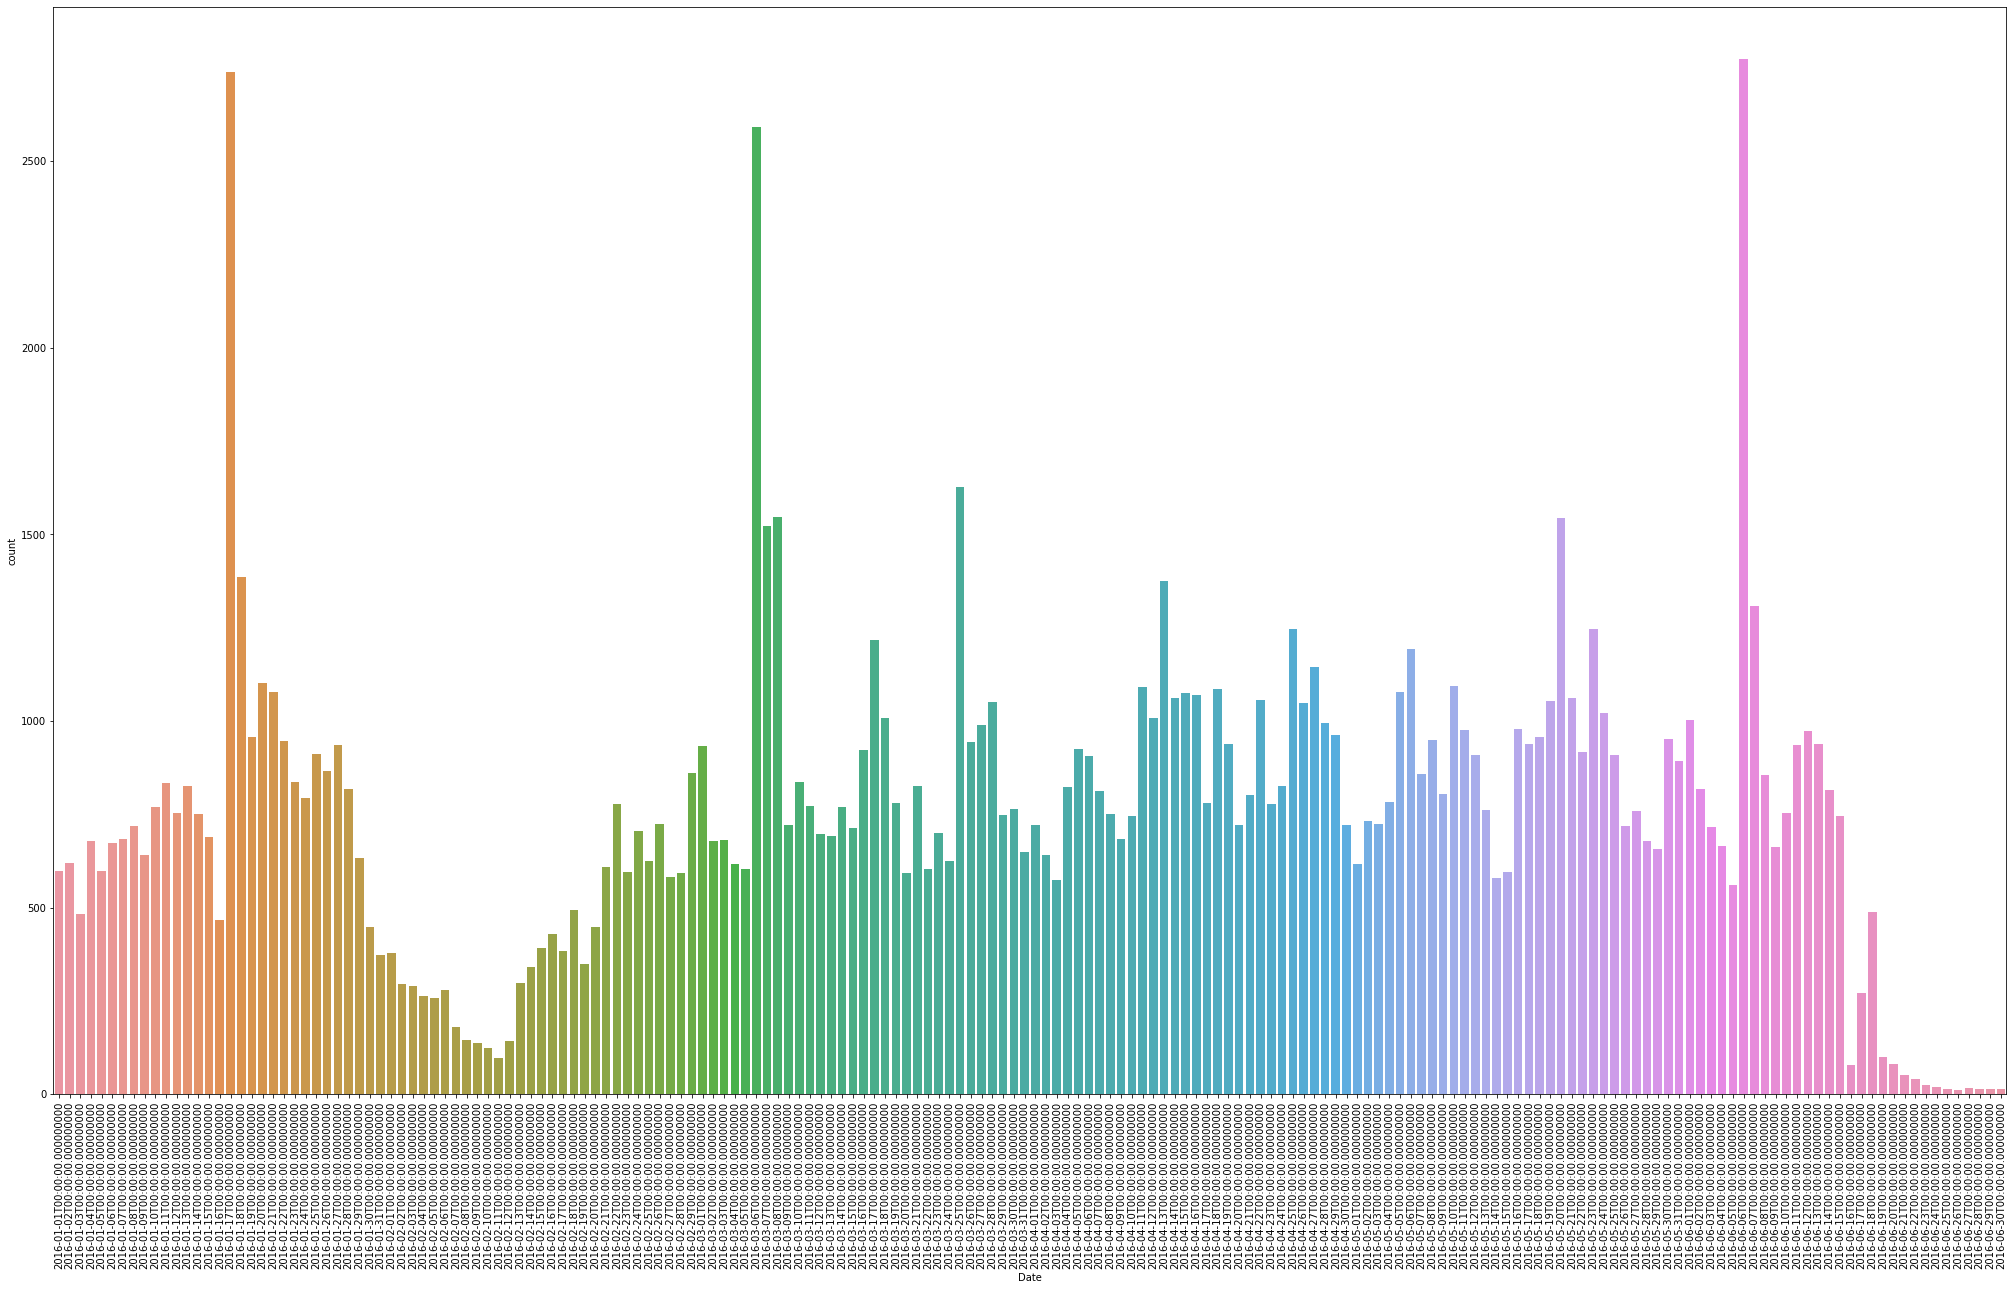

In [87]:
plt.figure(figsize=(35,20))
ax = sns.countplot(date_redeemed_on["Date"])
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.show()

In [79]:
df_online_total = df_online.shape[0]
df_online_total

4557134

In [91]:
#Number of visits of each user
activity_online = df_online.groupby("User_id")["Count"].sum()
activity_online
#df_activity_online = df_online.groupby("User_id")["Count"].sum()

User_id
388           3
584           2
1147          2
1603          1
2723         34
           ... 
15499965    134
15499966     13
15499998      3
15499999    109
15500000      1
Name: Count, Length: 495410, dtype: int64

In [93]:
df_activity_online = pd.DataFrame(activity_online).reset_index()
df_activity_online.columns = ['User_id', 'ActivityCount']
df_activity_online.ActivityCount.describe()

count    495410.000000
mean         18.372225
std          39.382876
min           1.000000
25%           4.000000
50%           9.000000
75%          20.000000
max        5786.000000
Name: ActivityCount, dtype: float64

In [82]:
df_activity_online[df_activity_online["ActivityCount"]==5786] 

,User_id,ActivityCount
368241,14015266,5786


In [94]:
df_online[(df_online["User_id"]==14015266)].head(50)

,User_id,Merchant_id,Action,Coupon_id,Discount_rate,Date_received,Date,Count
4618693,14015266,10001,0,NaN,NaN,NaT,2016-01-15,1
4618694,14015266,10001,0,NaN,NaN,NaT,2016-01-16,1
4618695,14015266,10001,0,NaN,NaN,NaT,2016-01-18,1
4618696,14015266,10001,0,NaN,NaN,NaT,2016-02-18,3
4618697,14015266,10001,0,NaN,NaN,NaT,2016-02-19,3
4618698,14015266,10001,0,NaN,NaN,NaT,2016-02-29,1
4618699,14015266,10001,0,NaN,NaN,NaT,2016-03-17,3
4618700,14015266,10001,0,NaN,NaN,NaT,2016-03-18,1
4618701,14015266,10001,0,NaN,NaN,NaT,2016-04-01,1
4618702,14015266,10001,0,NaN,NaN,NaT,2016-04-20,1


#### Maximum data for online are of clicks,  but for offline each entry represents a single visit of the user

## Analysis

#### User and User's merchant preference

In [96]:
#User and user's merchant preference
freq_visits = pd.DataFrame(df_of_unique.groupby(['User_id','Merchant_id']).size()).reset_index()
freq_visits.columns = ['User_id','Merchant_id','Visits']
freq_visits['Visits'].shape

(921146,)

### Plot for frequency of user-merchant visits

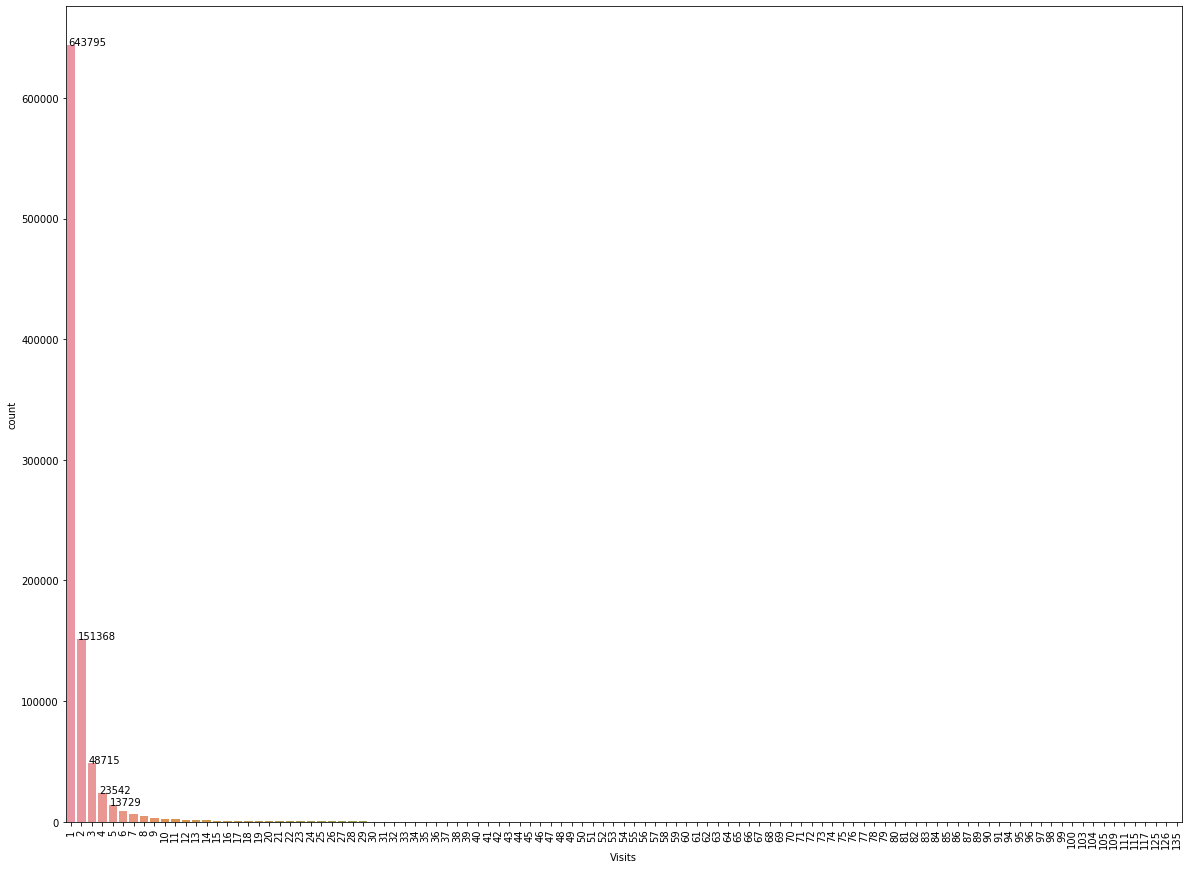

In [97]:
plt.figure(figsize=(20,15))
ax = sns.countplot(freq_visits['Visits'])
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
i = 4
for p in ax.patches:
        ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+50))
        i-=1
        if i <0:
            break
plt.show()

For offline:<br>
Around 69% of times the frequency of user-merchant pair is 1.<br>
For online:<br>
Around 79.4% of times the frequency of user-merchant pair is 1.<br>
So,in online as well as in offline, users don't prefer any certain set of merchants.

#### For any user-merchant pair, the distance should remain constant

In [98]:
user_merchant_distance = pd.DataFrame(df_of.groupby(['User_id','Merchant_id'])['Distance'].nunique()).reset_index()

In [99]:
user_merchant_distance['Distance'].unique()

array([1, 0])

Unique distance values for a user-merchant pair are 0 (for nan distance value) and 1.<br>
This shows for any user-merchant pair, the distance value remains constant.

#### Discount Rate should be constant for a particular coupon ids

In [100]:
# df_on.groupby(['Coupon_id'])['Discount_rate'].nunique().unique()

In [101]:
df_of.groupby(['Coupon_id'])['Discount_rate'].nunique().unique()

array([1])

For online and offline:<br>
For any coupon id, its discount remains constant.


#### Non Purchasers do not get enough coupons. (online)

In [104]:
user_action = df_online_actions.groupby(['User_id'])['Action_0','Action_1','Action_2'].sum()
user_action.head()

,Action_0,Action_1,Action_2
User_id,,,
4,0,1,1
36,1,0,0
64,2,1,0
144,1,0,0
165,0,1,0


In [105]:
purchaser = user_action[user_action['Action_1']!=0]         #users with atleast 1 buy
non_purchaser = user_action[user_action['Action_1']==0]     #users with only click entries
purchaser.head()

,Action_0,Action_1,Action_2
User_id,,,
4,0,1,1
64,2,1,0
165,0,1,0
184,0,2,0
209,1,4,0


Total online users: 762,858 <br>
Purchaser(have atleast 1 buy action) : 54%<br>
Non Purchaser(no buy action) : 46%<br>
Coupon Distribtion:<br>
Total coupons distributed 655898 <br>
73% of the coupons distributed goes to purchasers and 27% goes to non purchasers

#### A user should redeem a coupon to the nearest store

In [107]:
offline_redeemed = df_of_unique[(df_of_unique['Date'].isna()==False) & (df_of_unique['Coupon_id'].isna()==False)]
len(offline_redeemed['Coupon_id'].unique())

6865

### CountPlot for distance attribute (when coupon was redeemed)

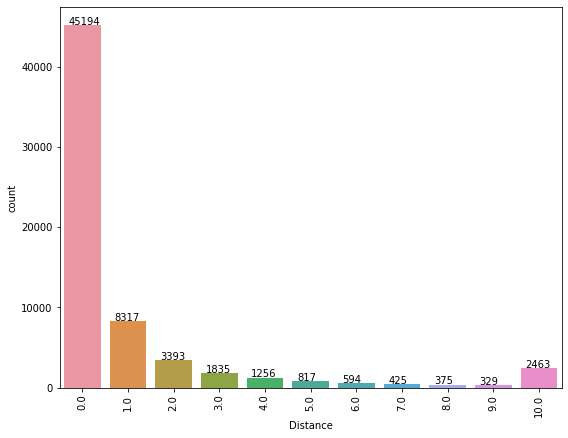

In [108]:
plt.figure(figsize=(9,7))
ax = sns.countplot(offline_redeemed['Distance'])
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
for p in ax.patches:
        ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+50))
plt.show()

When a coupon is redeemed offline, 61% of the times it is redeemed at a store which is at 0 (less than 500m) distance

In [109]:
offline_redeemed[offline_redeemed['Distance'].isna()].shape

(8066, 8)

#### Discount and Redemption

In [110]:
#Funtion to convert discount ratio to discount rate
def convert_discount(discount):
    values = []
    for i in discount:
        if ':' in i:
            i = i.split(':')
            rate = round((int(i[0]) - int(i[1]))/int(i[0]),2)
            values.append([int(i[0]),int(i[1]),rate])
        elif '.' in i:
            i = float(i)
            x = 100*i
            values.append([100,int(100-x),i])
            
    discounts = dict(zip(discount,values))      
    return discounts
    

# convert_discount(list(df_of['Discount_rate']))

For Offline:

In [112]:
#number of unique discounts offered to offline users
len(df_of['Discount_rate'].unique())

46

### CountPlot for discount ratios (offline)

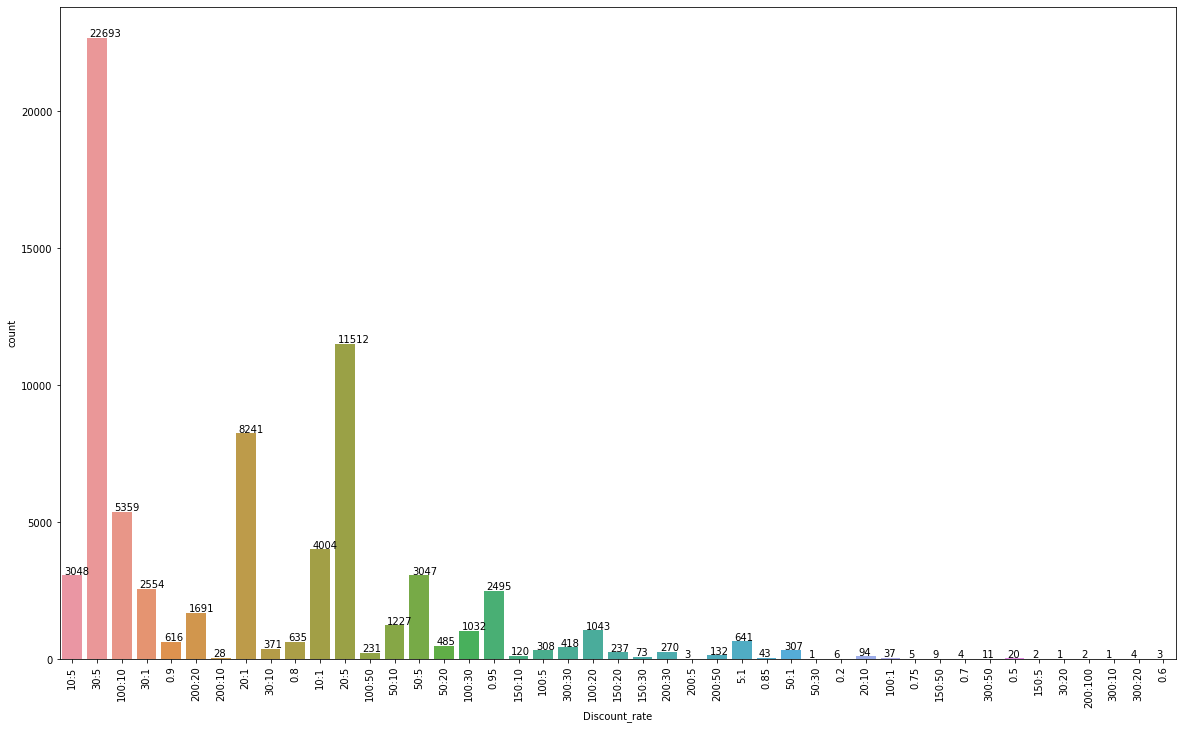

In [97]:
plt.figure(figsize=(20,12))
ax = sns.countplot(offline_redeemed['Discount_rate'])
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
for p in ax.patches:
        ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+50))
plt.show()

In [113]:
#For offline: count of coupons released for each discount rate
discount = df_of['Discount_rate'].value_counts()
of_discount = pd.DataFrame(discount).reset_index()
of_discount.columns = ['Discount_rate','Total_coupons']


In [114]:
#For offline: count of coupons redeemed for each discount rate
discount_red = offline_redeemed['Discount_rate'].value_counts()
of_discount_redeemed = pd.DataFrame(discount_red).reset_index()
of_discount_redeemed.columns = ['Discount_rate','Coupons_Redeemed']
of_discount_redeemed.head()

,Discount_rate,Coupons_Redeemed
0,30:5,22693
1,20:5,11512
2,20:1,8241
3,100:10,5359
4,10:1,4004


In [115]:
#Ratio = Coupons Redeemed/Coupons Released
df_discount_of = of_discount.merge(of_discount_redeemed)
df_discount_of['Ratio'] = df_discount_of['Coupons_Redeemed']/df_discount_of['Total_coupons']
df_discount_of['Discount'] = df_discount_of['Discount_rate']
df_discount_of.head()

,Discount_rate,Total_coupons,Coupons_Redeemed,Ratio,Discount
0,30:5,270712,22693,0.083827,30:5
1,100:10,182554,5359,0.029356,100:10
2,200:20,111046,1691,0.015228,200:20
3,20:5,91013,11512,0.126487,20:5
4,20:1,51705,8241,0.159385,20:1


Converting offline discount ratios to discount rates along with original price and discounted price

In [116]:
df_discount_of['Discount_rate'] = df_discount_of['Discount_rate'].map(convert_discount(list(of_discount_redeemed['Discount_rate'])))

In [117]:
df_discount_of[['Original_price','Discounted_price','Rate']] = pd.DataFrame(df_discount_of.Discount_rate.values.tolist(), index= df_discount_of.index)
df_discount_of.head()


,Discount_rate,Total_coupons,Coupons_Redeemed,Ratio,Discount,Original_price,Discounted_price,Rate
0,"[30, 5, 0.83]",270712,22693,0.083827,30:5,30,5,0.83
1,"[100, 10, 0.9]",182554,5359,0.029356,100:10,100,10,0.90
2,"[200, 20, 0.9]",111046,1691,0.015228,200:20,200,20,0.90
3,"[20, 5, 0.75]",91013,11512,0.126487,20:5,20,5,0.75
4,"[20, 1, 0.95]",51705,8241,0.159385,20:1,20,1,0.95


For Online:<br>
60% fixed discounts

In [119]:
online_redeemed = df_on_unique[(df_on_unique['Date'].isna()==False) & (df_on_unique['Coupon_id'].isna()==False)  & (df_on_unique['Coupon_id']!='fixed')]
online_redeemed.head()

,User_id,Merchant_id,Action,Coupon_id,Discount_rate,Date_received,Date,Count
14,209,27710,1,100081876,150:10,2016-05-14,2016-05-14,1
61,387,14305,1,100032161,10:5,2016-05-16,2016-05-20,1
116,696,26705,1,100128459,30:20,2016-02-13,2016-02-13,1
196,944,47311,1,100225309,100:5,2016-05-26,2016-05-26,1
218,1202,18907,1,100102905,300:30,2016-02-25,2016-02-25,1


### CountPlot for discount ratios (online)

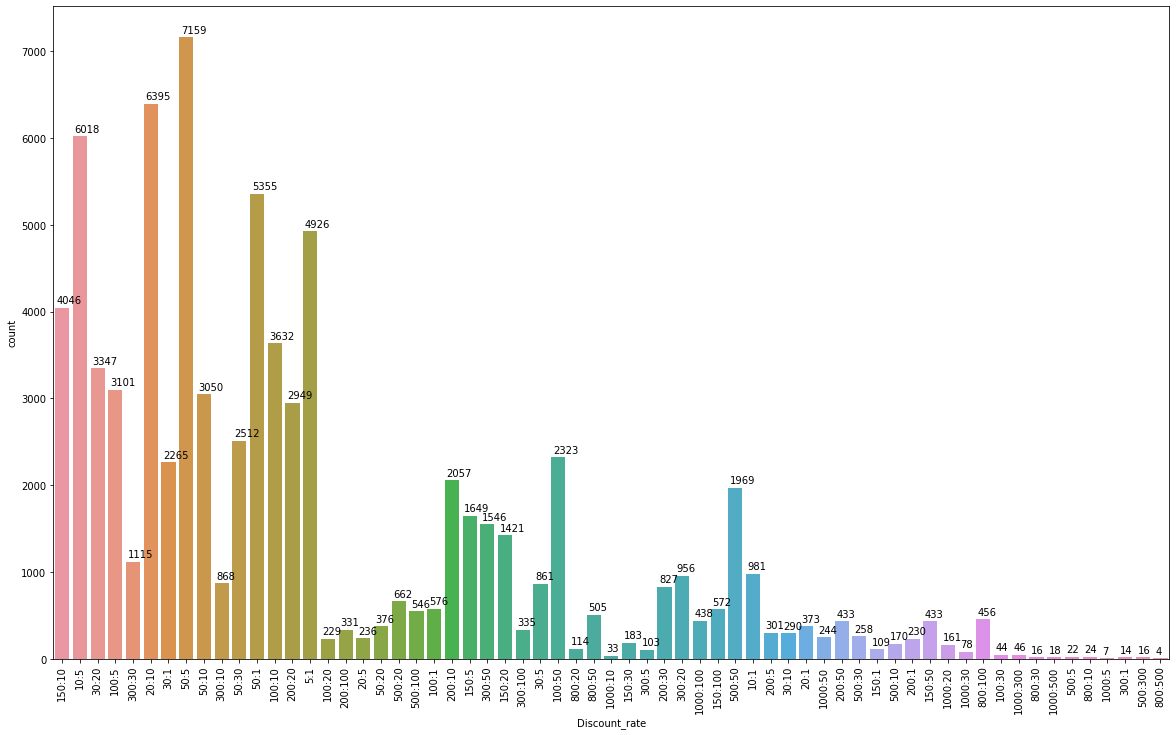

In [120]:
plt.figure(figsize=(20,12))
ax = sns.countplot(online_redeemed['Discount_rate'])
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
for p in ax.patches:
        ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+50))
plt.show()

In [121]:
type(df_on['Discount_rate'][0])

str

### Redemption Score of Merchants

In [123]:
#For each merchant(offline): number of coupons they release and number of those coupons redeemd
merch_coupons_offline = df_of_unique[(df_of_unique['Coupon_id'].isna()==False)].groupby(['Merchant_id'])['Coupon_id','Date'].count()
merch_coupons_offline['Redemption_ratio'] = merch_coupons_offline['Date']/merch_coupons_offline['Coupon_id']
merch_coupons_offline.columns = ['Total_coupons','NumberRedeemed','Redemption_ratio']
merch_coupons_offline.head()

,Total_coupons,NumberRedeemed,Redemption_ratio
Merchant_id,,,
2,7,0,0.000000
3,10,1,0.100000
4,7,5,0.714286
5,28,3,0.107143
8,2,0,0.000000


#### Filling Nan for Distance

In [111]:
df_of_unique['Distance'].fillna(df_of_unique['Distance'].mean(), inplace=True)
df_of_unique['Distance'] = df_of_unique.Distance.astype(int)

In [112]:
df_of_unique.tail(5)

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date,Count
1716986,7360967,3103,NaN,NaN,2,NaT,2016-01-20,1
1716987,7360967,6485,10323.0,20:5,1,2016-03-22,NaT,2
1716988,7361024,1433,8735.0,30:5,10,2016-02-11,NaT,1
1716989,7361032,2146,11173.0,100:10,2,2016-01-29,NaT,1
1716990,7361032,7019,3887.0,100:10,8,2016-01-29,NaT,1


In [113]:
offline_redeemed = df_of_unique[(df_of_unique['Date'].isna()==False) & (df_of_unique['Coupon_id'].isna()==False)]

#### CountPlot for distance attribute (when coupon was redeemed)

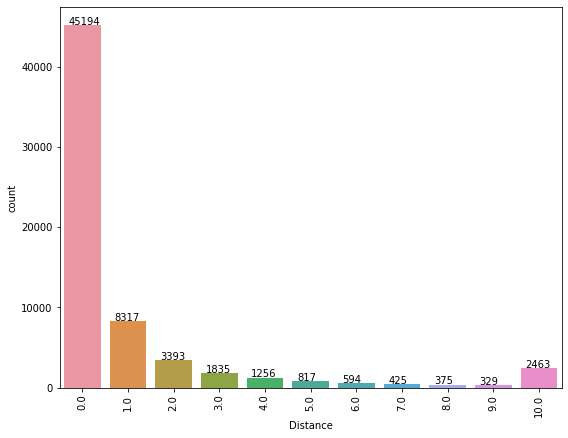

In [124]:
plt.figure(figsize=(9,7))
ax = sns.countplot(offline_redeemed['Distance'])
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
for p in ax.patches:
        ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+50))
plt.show()

### Merchant and Average Distance of its customers

In [129]:
merch_dist = df_of_unique.groupby(['Merchant_id'])['Distance'].agg(['mean','count'])
merch_dist.head(7)

,mean,count
Merchant_id,,
1,0.000000,14
2,6.181818,11
3,5.375000,16
4,0.000000,39
5,1.493151,73
6,0.114754,61
7,5.666667,3


In [130]:
merch_dist['mean'].describe()

count    8218.000000
mean        2.295972
std         2.203699
min         0.000000
25%         0.532270
50%         1.725000
75%         3.497549
max        10.000000
Name: mean, dtype: float64

### Merchant and Discounts

In [131]:
#converting discount ratios to rates for merchant analysis
merch_discount = df_of_unique[df_of_unique['Coupon_id'].isna()==False]
merch_discount['Ratio_list'] = merch_discount['Discount_rate']
rates = list(merch_discount['Discount_rate'].unique())
merch_discount

/Users/mahimaarora/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date,Count,Ratio_list
0,4,1433,8735.0,30:5,10.0,2016-02-14,NaT,1,30:5
1,4,1469,2902.0,0.95,10.0,2016-06-07,NaT,1,0.95
2,35,3381,1807.0,300:30,0.0,2016-01-30,NaT,1,300:30
3,35,3381,9776.0,10:5,0.0,2016-01-29,NaT,1,10:5
4,35,3381,11951.0,200:20,0.0,2016-01-29,NaT,1,200:20
...,...,...,...,...,...,...,...,...,...
1716984,7360967,3103,2375.0,30:1,2.0,2016-01-20,NaT,1,30:1
1716987,7360967,6485,10323.0,20:5,1.0,2016-03-22,NaT,2,20:5
1716988,7361024,1433,8735.0,30:5,10.0,2016-02-11,NaT,1,30:5
1716989,7361032,2146,11173.0,100:10,2.0,2016-01-29,NaT,1,100:10


In [132]:
merch_discount['Ratio_list'] = merch_discount['Ratio_list'].map(convert_discount(rates))
merch_discount

/Users/mahimaarora/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date,Count,Ratio_list
0,4,1433,8735.0,30:5,10.0,2016-02-14,NaT,1,"[30, 5, 0.83]"
1,4,1469,2902.0,0.95,10.0,2016-06-07,NaT,1,"[100, 5, 0.95]"
2,35,3381,1807.0,300:30,0.0,2016-01-30,NaT,1,"[300, 30, 0.9]"
3,35,3381,9776.0,10:5,0.0,2016-01-29,NaT,1,"[10, 5, 0.5]"
4,35,3381,11951.0,200:20,0.0,2016-01-29,NaT,1,"[200, 20, 0.9]"
...,...,...,...,...,...,...,...,...,...
1716984,7360967,3103,2375.0,30:1,2.0,2016-01-20,NaT,1,"[30, 1, 0.97]"
1716987,7360967,6485,10323.0,20:5,1.0,2016-03-22,NaT,2,"[20, 5, 0.75]"
1716988,7361024,1433,8735.0,30:5,10.0,2016-02-11,NaT,1,"[30, 5, 0.83]"
1716989,7361032,2146,11173.0,100:10,2.0,2016-01-29,NaT,1,"[100, 10, 0.9]"


In [133]:
merch_discount[['Original_price','Discounted_price','Rate']] = pd.DataFrame(merch_discount.Ratio_list.values.tolist(), index= merch_discount.index)
merch_discount

/Users/mahimaarora/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date,Count,Ratio_list,Original_price,Discounted_price,Rate
0,4,1433,8735.0,30:5,10.0,2016-02-14,NaT,1,"[30, 5, 0.83]",30,5,0.83
1,4,1469,2902.0,0.95,10.0,2016-06-07,NaT,1,"[100, 5, 0.95]",100,5,0.95
2,35,3381,1807.0,300:30,0.0,2016-01-30,NaT,1,"[300, 30, 0.9]",300,30,0.90
3,35,3381,9776.0,10:5,0.0,2016-01-29,NaT,1,"[10, 5, 0.5]",10,5,0.50
4,35,3381,11951.0,200:20,0.0,2016-01-29,NaT,1,"[200, 20, 0.9]",200,20,0.90
...,...,...,...,...,...,...,...,...,...,...,...,...
1716984,7360967,3103,2375.0,30:1,2.0,2016-01-20,NaT,1,"[30, 1, 0.97]",30,1,0.97
1716987,7360967,6485,10323.0,20:5,1.0,2016-03-22,NaT,2,"[20, 5, 0.75]",20,5,0.75
1716988,7361024,1433,8735.0,30:5,10.0,2016-02-11,NaT,1,"[30, 5, 0.83]",30,5,0.83
1716989,7361032,2146,11173.0,100:10,2.0,2016-01-29,NaT,1,"[100, 10, 0.9]",100,10,0.90


In [119]:
merch_discount.sort_values(by = ['Merchant_id'])

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date,Count,Ratio_list,Original_price,Discounted_price,Rate
1542839,6621282,2,7354.0,100:20,2,2016-05-17,NaT,1,"[100, 20, 0.8]",100,20,0.80
385637,1657650,2,7354.0,100:20,10,2016-05-18,NaT,1,"[100, 20, 0.8]",100,20,0.80
251273,1091900,2,7354.0,100:20,10,2016-05-19,NaT,1,"[100, 20, 0.8]",100,20,0.80
492408,2121631,2,7354.0,100:20,10,2016-05-20,NaT,1,"[100, 20, 0.8]",100,20,0.80
880686,3789187,2,7354.0,100:20,10,2016-05-16,NaT,1,"[100, 20, 0.8]",100,20,0.80
...,...,...,...,...,...,...,...,...,...,...,...,...
57220,250422,8856,83.0,10:1,0,2016-06-06,NaT,1,"[10, 1, 0.9]",10,1,0.90
1716923,7360651,8856,83.0,10:1,0,2016-06-06,NaT,1,"[10, 1, 0.9]",10,1,0.90
1675872,7186324,8856,5495.0,20:1,1,2016-06-14,NaT,1,"[20, 1, 0.95]",20,1,0.95
234176,1016869,8856,5495.0,20:1,0,2016-06-15,NaT,1,"[20, 1, 0.95]",20,1,0.95


In [136]:
#avg discounts each merchant offers
merch_discount.groupby(['Merchant_id'])['Rate'].mean()

Merchant_id
2       0.800000
3       0.670000
4       0.830000
5       0.750000
8       0.500000
          ...   
8849    0.950000
8850    0.950000
8852    0.950000
8854    0.950000
8856    0.943243
Name: Rate, Length: 5599, dtype: float64

#### CountPlot of Discount rates(offline)

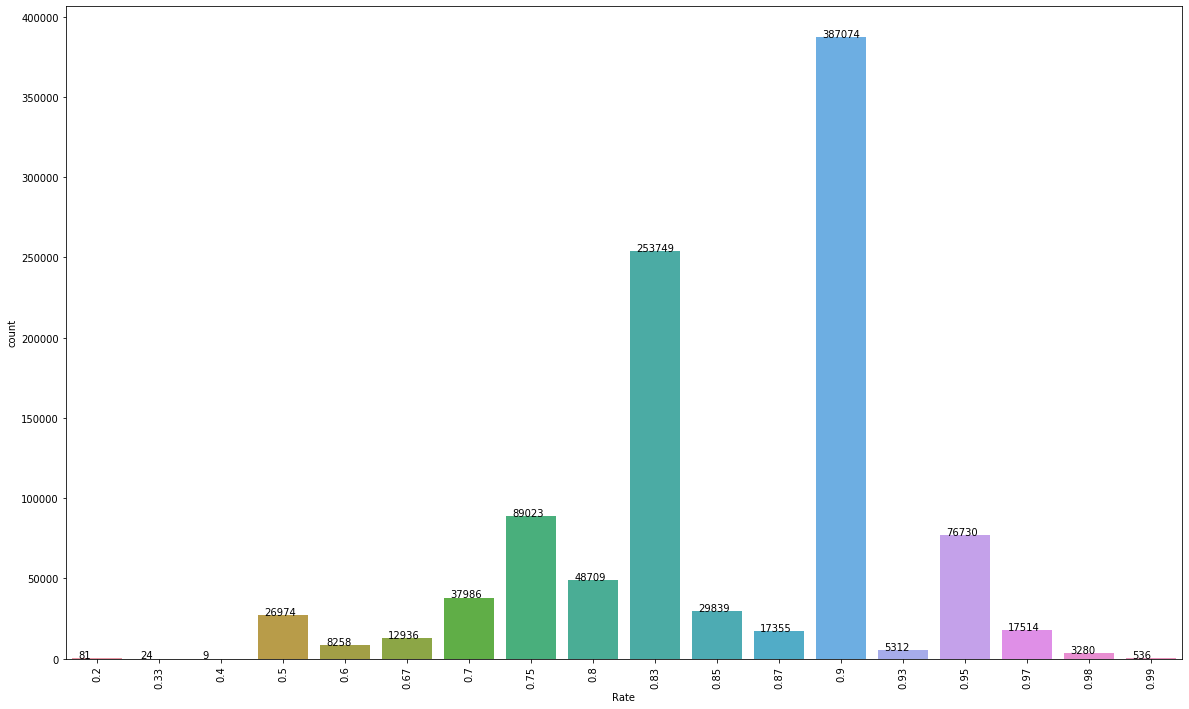

In [137]:
plt.figure(figsize=(20,12))
ax = sns.countplot(merch_discount['Rate'])
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
for p in ax.patches:
        ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+50))
plt.show()

In [138]:
merch_discount[merch_discount['Rate']>0.84].shape

(537640, 12)

### Discount offered and Coupon Redemtion Score

In [141]:
rate_ratio = merch_discount.groupby(['Rate'])['Coupon_id','Date'].count()
rate_ratio['RedemtionRatio'] = rate_ratio['Date']/rate_ratio['Coupon_id']
rate_ratio.columns = ['Total_coupons','CouponsRedeemed','RedemtionRatio']
rate_ratio.head()

,Total_coupons,CouponsRedeemed,RedemtionRatio
Rate,,,
0.20,81,6,0.074074
0.33,24,1,0.041667
0.40,9,1,0.111111
0.50,26974,3395,0.125862
0.60,8258,488,0.059094


#### User and coupon redemption

Cases where we have enteries for user getting a coupon and redeeming it

#### Online

In [124]:
user_getandredeem_on = df_on.groupby(['User_id','Coupon_id'])['Discount_rate','Date'].count()
user_getandredeem_on['RedeemFlag'] = (user_getandredeem_on['Date']>0) & (user_getandredeem_on['Date']<user_getandredeem_on['Discount_rate'])
user_getandredeem_on[user_getandredeem_on['RedeemFlag']==True].shape

(10471, 3)

In [125]:
df_on[(df_on['User_id']==44958) & (df_on['Coupon_id']=='100044462')]

,User_id,Merchant_id,Action,Coupon_id,Discount_rate,Date_received,Date
Index,,,,,,,
7047394,44958,28302,1,100044462,10:5,20160510.0,20160510.0
7047395,44958,28302,2,100044462,10:5,20160510.0,NaN


Cases where data received is same

In [126]:
user_getandredeem_on_same = df_on.groupby(['User_id','Coupon_id','Date_received'])['Discount_rate','Date'].count()
user_getandredeem_on_same['RedeemFlag'] = (user_getandredeem_on_same['Date']>0) & (user_getandredeem_on_same['Date']<user_getandredeem_on_same['Discount_rate'])
user_getandredeem_on_same[user_getandredeem_on_same['RedeemFlag']==True].shape

(10421, 3)

#### Offline

In [143]:
user_getandredeem_of = df_of.groupby(['User_id','Coupon_id'])['Discount_rate','Date'].count()
user_getandredeem_of['RedeemFlag'] = (user_getandredeem_of['Date']>0) & (user_getandredeem_of['Date']<user_getandredeem_of['Discount_rate'])
user_getandredeem_of[user_getandredeem_of['RedeemFlag']==True].shape

(10343, 3)

In [149]:
user_getandredeem_of[user_getandredeem_of['RedeemFlag']==True].head(10)

Discount_rate  Date  RedeemFlag
User_id Coupon_id                                 
687     14031.0                2     1        True
696     3726.0                 2     1        True
947     12414.0                2     1        True
1318    2810.0                 2     1        True
        9614.0                 2     1        True
2266    4727.0                 6     3        True
5551    2062.0                 2     1        True
        6615.0                 2     1        True
5569    5582.0                 3     2        True
8107    1268.0                 2     1        True

In [150]:
df_of[(df_of['User_id']==2266) & (df_of['Coupon_id']==4727.0)]

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date
96264,2266,7422,4727.0,0.8,6.0,20160304.0,20160304.0
96265,2266,7422,4727.0,0.8,6.0,20160528.0,20160528.0
96267,2266,7422,4727.0,0.8,6.0,20160305.0,NaN
96268,2266,7422,4727.0,0.8,6.0,20160612.0,NaN
96269,2266,7422,4727.0,0.8,6.0,20160518.0,NaN
96270,2266,7422,4727.0,0.8,6.0,20160312.0,20160312.0


In [151]:
user_getandredeem_of_same= df_of.groupby(['User_id','Coupon_id','Date_received'])['Discount_rate','Date'].count()
user_getandredeem_of_same['RedeemFlag'] = (user_getandredeem_of_same['Date']>0) & (user_getandredeem_of_same['Date']<user_getandredeem_of_same['Discount_rate'])
user_getandredeem_of_same[user_getandredeem_of_same['RedeemFlag']==True].shape

(0, 3)

no cases where date received of coupon is same( for get coupon and redeem coupon)

#### Date Received and Number of Coupon Released on that day

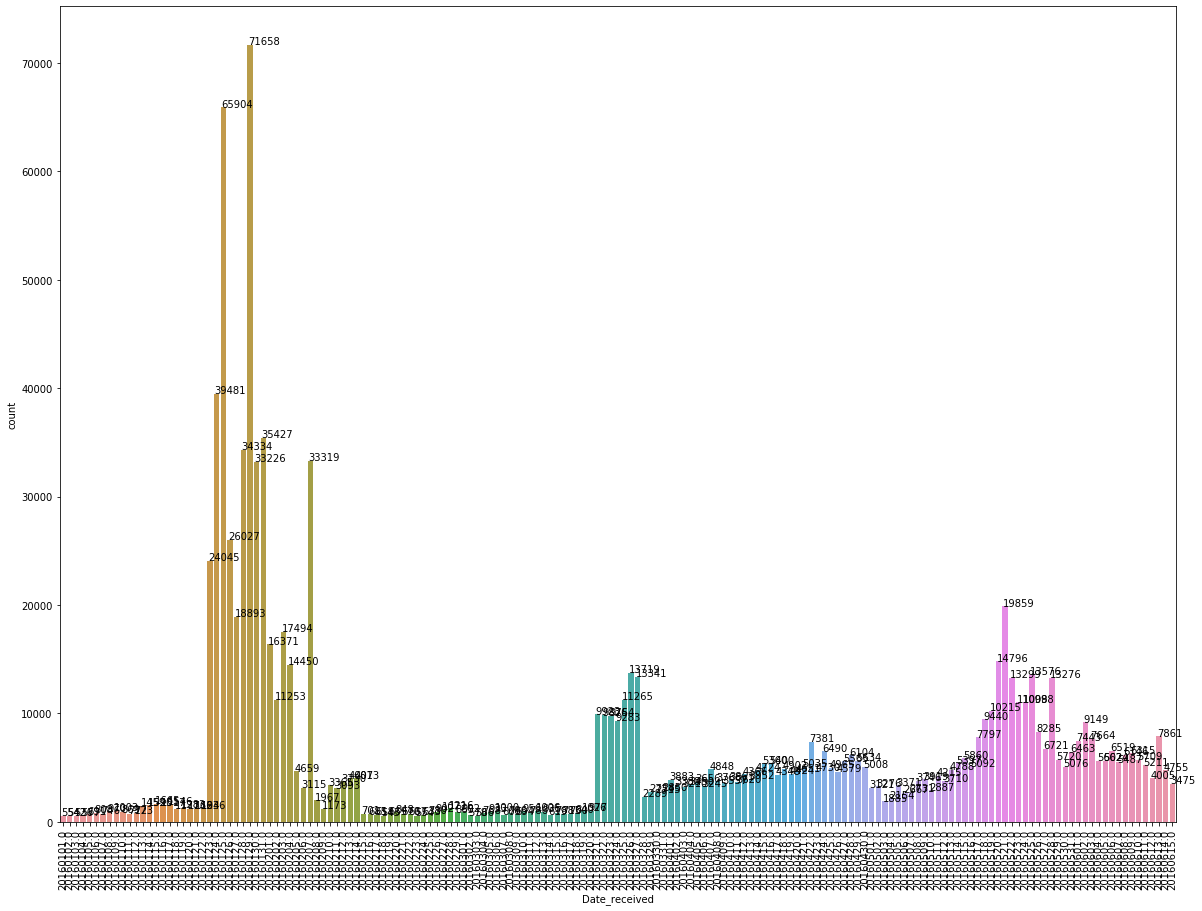

In [152]:
#offline
plt.figure(figsize=(20,15))
ax = sns.countplot(df_of['Date_received'])
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
for p in ax.patches:
        ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+50))
plt.show()